In [93]:
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import os, sys
import cftime
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import Huber

## Data

In [94]:
def read_csv(file_path, filename, varname):
    """
    Reads a CSV file, skips the first line and converts into into xarray.
    """
    ds = pd.read_csv(file_path+filename, skiprows=1, header=None, names=['time', varname], na_values=['NaN',-9999])
    ds['time'] = pd.to_datetime(ds['time'], format='%Y-%m-%d')

    ds = ds.set_index('time')
    ds = ds.to_xarray()
    ds['time'] = ds['time'].astype('datetime64[ns]')
    ds[varname] = ds[varname].astype('float32')

    return ds

def read_csv2(filepath):
    """
    Reads a CSV file and converts it to an xarray Dataset.
    """

    df = pd.read_csv(filepath, sep=';', skipinitialspace=True)
    
    df.columns = ['time', 'q']
    df['time'] = pd.to_datetime(df['time'], format='%Y%m%d')
    df.set_index('time', inplace=True)
    ds = df.to_xarray()
    
    return ds

def anom(xarr):
    #monthly mean anomaly (No-detrened)

    xarr_clm = xarr.groupby('time.month').mean('time')
    xarr_ano = xarr.groupby('time.month') - xarr_clm
    return xarr_ano, xarr_clm

In [95]:
path = '/home/amnd25/Desktop/Milano/Test_CDP_PhD/'

dmi = read_csv(path,'dmi.had.long.csv','dmi')
mei = read_csv(path,'mei.ext.long.csv','mei') # multivariate ENSO index
nao = read_csv(path,'nao.long.csv','nao')
nino3 = read_csv(path,'nino3.long.anom.csv','nino3')
nino4 = read_csv(path,'nino4.long.anom.csv','nino4')
nino12 = read_csv(path,'nino12.long.anom.csv','nino12')
nino34 = read_csv(path,'nino34.long.anom.csv','nino34')
pdo = read_csv(path,'pdo.timeseries.sstens.csv','pdo') # Pacific Decadal Oscillation
soi = read_csv(path,'soi.long.csv','soi') # Southern Oscillation Index
tsa = read_csv(path,'tsa.long.csv','tsa') # Tropical Southern Atlantic

data_names = ['dmi', 'mei', 'nao', 'nino3', 'nino4', 'nino12', 'nino34', 'pdo', 'soi', 'tsa'] # 10 climate indices
data_list =[dmi, mei, nao, nino3, nino4, nino12, nino34, pdo, soi, tsa]

In [96]:
streamflow = read_csv2(path+'Zambezi_at_BigTree_VicFalls_obs_discharge.txt')

streamflow_anom, streamflow_clm = anom(streamflow.q)

In [97]:
streamflow.q

<xarray.DataArray 'q' (time: 34252)> Size: 274kB
array([ 100.,  100.,  100., ..., 1671., 1635., 1587.])
Coordinates:
  * time     (time) datetime64[ns] 274kB 1924-10-01 1924-10-02 ... 2018-07-11

In [98]:
data_names = ['nino3', 'nino4', 'nino12', 'nino34', 'pdo', 'soi']
data_list =[nino3, nino4, nino12, nino34, pdo, soi]
data_list_time_cropped = [ds.sel(time=slice('1924-10-01', '2018-07-11')) for ds in data_list]

## Model

### Data Initialization

In [99]:
window_size = 36 # 3 years
lag = 3
forecast_horizon = 3  

monthly_streamflow = streamflow_anom.resample(time='MS').mean('time') # Resample to monthly values
monthly_streamflow = monthly_streamflow.dropna('time')

optimal_lags = {
    'nino3': 2,
    'nino4': 1,
    'nino12': 2,
    'nino34': 2,
    'pdo': 4,
    'soi': 4,
}

climate_matrix = []

for nome, ds in zip(data_names, data_list_time_cropped):
    index_monthly = ds[nome].resample(time='MS').mean('time') # Make sure they are monthly
    index_monthly = index_monthly.shift(time=optimal_lags[nome]) # Shift the index according to the optimal lag
    index_monthly = index_monthly.dropna('time') # Align with streamflow
    climate_matrix.append(index_monthly) 

climate_concat = xr.concat(climate_matrix, dim='variable') # All climate indices concatenated
climate_concat['variable'] = data_names
climate_df = climate_concat.transpose('time', 'variable').to_pandas() # Transpose to have time as index and variables as columns
# We transpose because we want to align the climate indices with the streamflow time series
climate_df.columns = data_names

streamflow_series = monthly_streamflow.to_pandas()
climate_df, streamflow_aligned = climate_df.align(streamflow_series, join='inner', axis=0) # join='inner' to keep only the common dates

In [100]:
df = pd.concat([streamflow_aligned, climate_df], axis=1) # Final DataFrame
df = df.dropna() 

df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12) # We can use sine and cosine to represent the month in a periodic way, capturing seasonality
df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12) # Will be used as features in the model

df['streamflow_anomaly'] = df.iloc[:, 0] - df.iloc[:, 0].rolling(window=12, center=True).mean() # Compute and add the anomaly as feature
df = df.dropna()

all_features_array = df.drop(columns=['streamflow_anomaly']).values # All features except the target
streamflow_array = df['streamflow_anomaly'].values # Target variable

X, y = [], []
dates = []

for i in range(window_size, len(df) - lag - forecast_horizon + 1): # Ensure we have enough data for the window and lag
    X_window = all_features_array[i - window_size:i]  # shape: (, 36, num_features)
    y_target = streamflow_array[i + lag : i + lag + forecast_horizon]  # shape: (, 3)
    prediction_date = df.index[i + lag]
    
    X.append(X_window)
    y.append(y_target)
    dates.append(prediction_date)

X = np.array(X)
y = np.array(y)
dates = np.array(dates)

print(" X shape:", X.shape)
print(" y shape:", y.shape)

 X shape: (1070, 36, 9)
 y shape: (1070, 3)


### Splitting training/testing

In [101]:
dates = df.index[window_size + lag : len(df) - forecast_horizon + 1].tolist() # Align dates with the length of X and y
if len(dates) < len(X): # Ensure dates match the length of X
    dates_aligned = list(dates) + [None] * (len(X) - len(dates))
else:
    dates_aligned = dates[:len(X)]

# Splitting: 80% train, 20% test, no shuffle because time series data should not be shuffled
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, dates_aligned, test_size=0.2, shuffle=False
)

### Standardization

In [102]:
scalers = []
X_train_scaled = np.zeros_like(X_train)
X_test_scaled = np.zeros_like(X_test)

for i in range(X.shape[2]):  # Iterate over each feature, standardizing each one separately
    scaler = RobustScaler()
    
    X_train_feat = X_train[:, :, i].reshape(-1, 1)  # Flatten time dimension for scaling
    scaler.fit(X_train_feat)  # Fit only on training
    
    X_train_scaled[:, :, i] = scaler.transform(X_train[:, :, i].reshape(-1, 1)).reshape(X_train[:, :, i].shape)
    X_test_scaled[:, :, i] = scaler.transform(X_test[:, :, i].reshape(-1, 1)).reshape(X_test[:, :, i].shape)
    
    scalers.append(scaler)

y_scaler = RobustScaler() # y needs to be standardized across all 3 forecasts (t+1, t+2, t+3)
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

### Model definition

In [103]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=False))
# return_sequences=False because we only need the last output for regression
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu')) # relu activation for non-linearity
model.add(Dense(3))  # 3 output: t+1, t+2, t+3

model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=1.0))

model.summary()

/home/amnd25/anaconda3/envs/milano/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,299 (91.01 KB)

 Trainable params: 23,299 (91.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Avoid overfitting
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1) # 

history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.3793 - val_loss: 0.2308 - learning_rate: 0.0010
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3385 - val_loss: 0.2241 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3377 - val_loss: 0.2291 - learning_rate: 0.0010
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2992 - val_loss: 0.2308 - learning_rate: 0.0010
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2958 - val_loss: 0.2373 - learning_rate: 0.0010
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2899 - val_loss: 0.2329 - learning_rate: 0.0010
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2841 - val_loss: 0.2359 - learning_rate: 0.0010
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2754 - val_loss: 0.2289 - learning_rate: 0.0010
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3150 - val_loss: 0.2414 - learning_rate: 0.0010
Epoch 10/1

### Predictions

In [ ]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

y_true = y_scaler.inverse_transform(y_test_scaled)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [112]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

for i, month in enumerate(['t+1', 't+2', 't+3']):
    rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    print(f"{month} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")


t+1 - RMSE: 406.36, MAE: 255.45
t+2 - RMSE: 406.66, MAE: 265.11
t+3 - RMSE: 415.15, MAE: 279.12


In [113]:
for i, month in enumerate(['t+1', 't+2', 't+3']):
    y_t = y_true[:, i]
    y_p = y_pred[:, i]

    q10 = np.percentile(y_t, 10)
    q90 = np.percentile(y_t, 90)

    extreme_mask = (y_t < q10) | (y_t > q90)
    rmse_extreme = np.sqrt(mean_squared_error(y_t[extreme_mask], y_p[extreme_mask]))
    print(f"{month} - RMSE on extremes (<10% or >90%): {rmse_extreme:.2f}")


t+1 - RMSE on extremes (<10% or >90%): 823.01
t+2 - RMSE on extremes (<10% or >90%): 814.99
t+3 - RMSE on extremes (<10% or >90%): 825.29


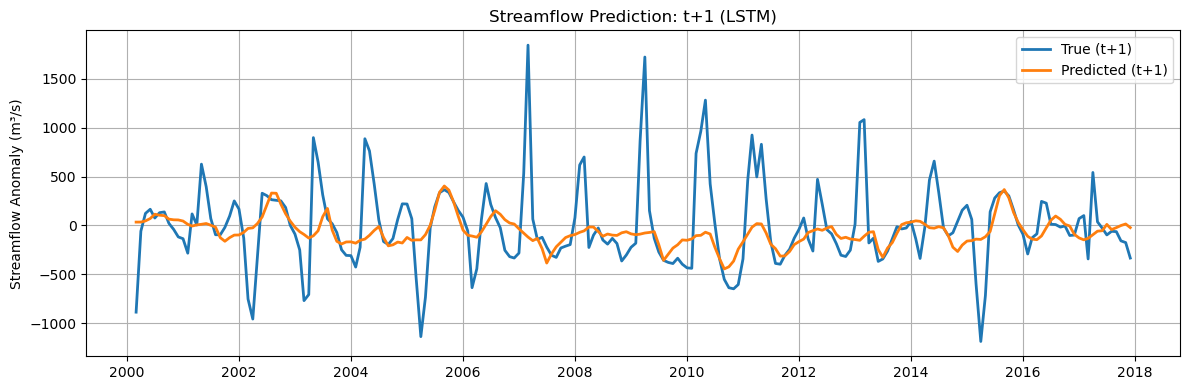

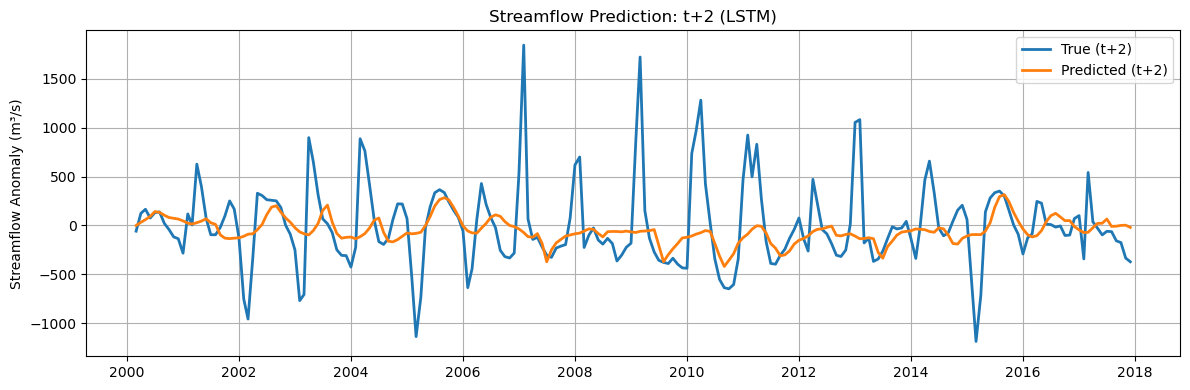

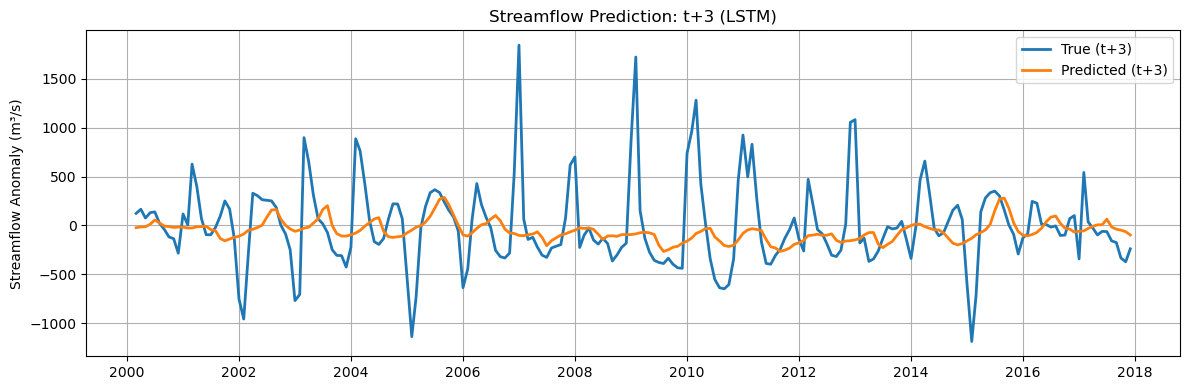

In [136]:
for month_idx in range(3):
    month_label = ['t+1', 't+2', 't+3'][month_idx]
    
    plt.figure(figsize=(12, 4))
    plt.plot(dates_test, y_true[:, month_idx], label=f'True ({month_label})', linewidth=2)
    plt.plot(dates_test, y_pred[:, month_idx], label=f'Predicted ({month_label})', linewidth=2)
    plt.ylabel("Streamflow Anomaly (m³/s)")
    plt.title(f"Streamflow Prediction: {month_label} (LSTM)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

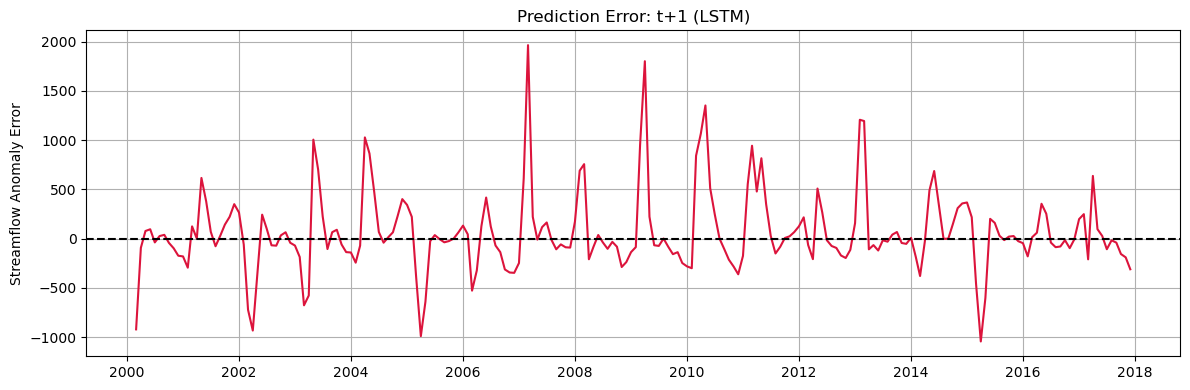

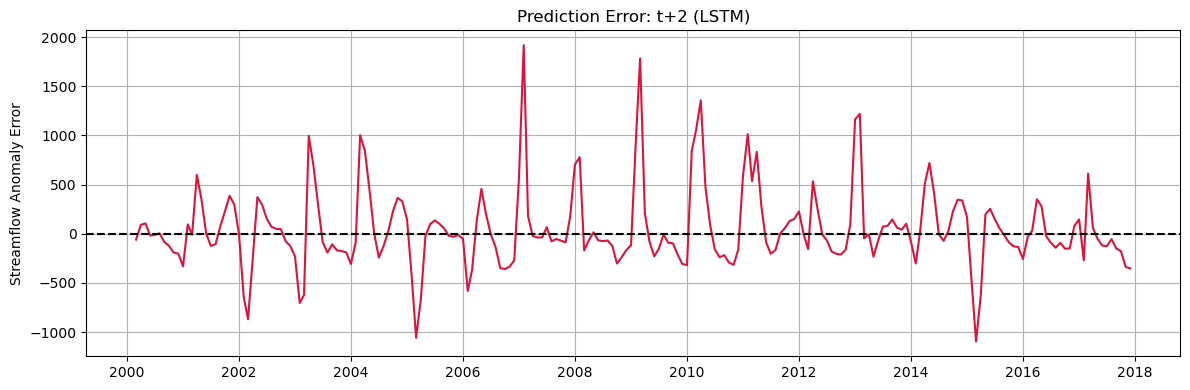

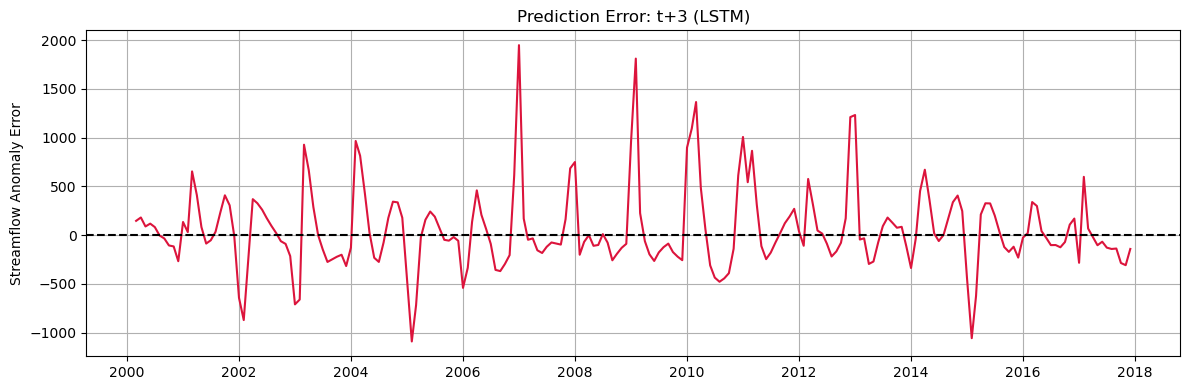

In [134]:
for month_idx in range(3):
    errors = y_true[:, month_idx] - y_pred[:, month_idx]
    
    plt.figure(figsize=(12, 4))
    plt.plot(dates_test, errors, label='Prediction Error', color='crimson')
    plt.axhline(0, linestyle='--', color='black')
    plt.ylabel('Streamflow Anomaly Error')  # o 'Streamflow Error (m³/s)' se hai fatto inverse_transform
    plt.title(f'Prediction Error: t+{month_idx + 1} (LSTM)' )
    plt.grid(True)
    plt.tight_layout()


 t+1 extremes evaluation
10th percentile threshold: -394.86
90th percentile threshold: 469.93
Mean Absolute Error (low flows)  : 497.038
Mean Absolute Error (high flows) : 942.174
Mean Absolute Error (overall)    : 255.448

 t+2 extremes evaluation
10th percentile threshold: -389.95
90th percentile threshold: 469.93
Mean Absolute Error (low flows)  : 483.606
Mean Absolute Error (high flows) : 942.427
Mean Absolute Error (overall)    : 265.113

 t+3 extremes evaluation
10th percentile threshold: -389.95
90th percentile threshold: 469.93
Mean Absolute Error (low flows)  : 507.330
Mean Absolute Error (high flows) : 948.048
Mean Absolute Error (overall)    : 279.116


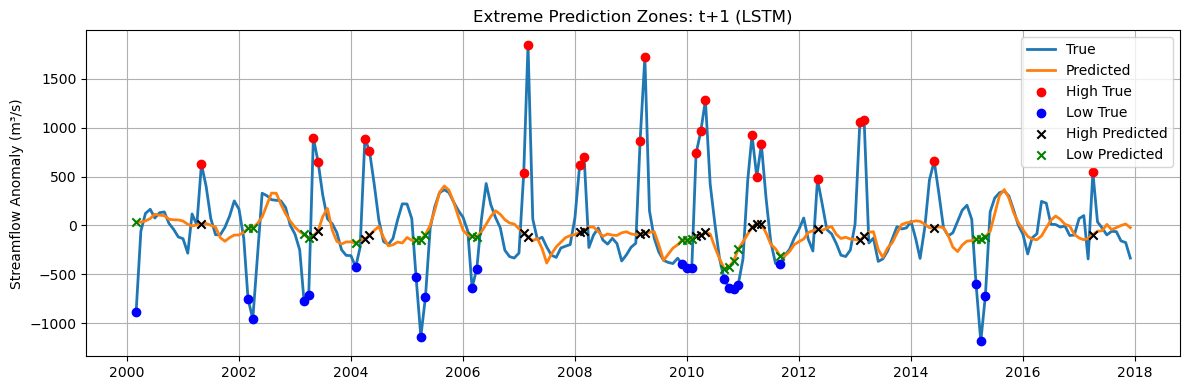

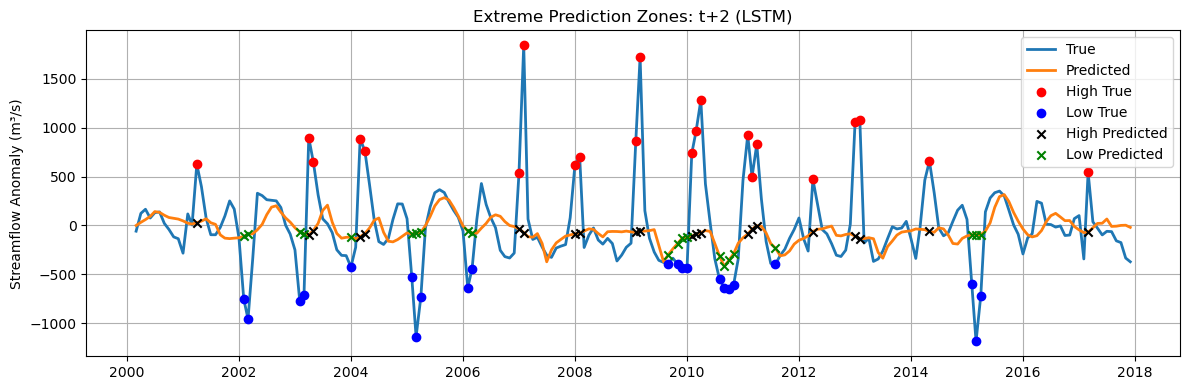

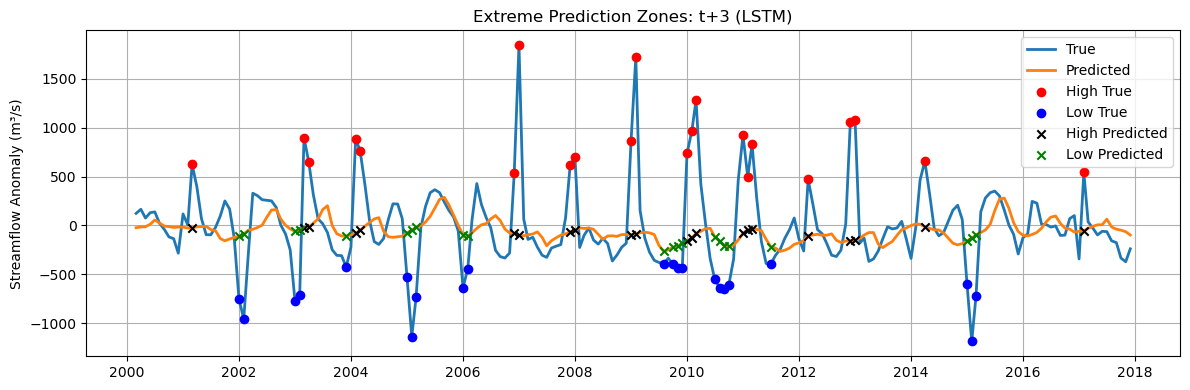

In [137]:
dates_test_np = np.array(dates_test)

for month_idx in range(3): # Estreme evaluation for each forecast horizon

    low_thresh = np.percentile(y_true[:, month_idx], 10) # Definition of extremes: 10th percentile
    high_thresh = np.percentile(y_true[:, month_idx], 90) # 90th percentile

    low_mask = y_true[:, month_idx] < low_thresh
    high_mask = y_true[:, month_idx] > high_thresh

    low_errors = np.abs(y_pred[:, month_idx][low_mask] - y_true[:, month_idx][low_mask])
    high_errors = np.abs(y_pred[:, month_idx][high_mask] - y_true[:, month_idx][high_mask])
    all_errors = np.abs(y_pred[:, month_idx] - y_true[:, month_idx])

    print(f"\n t+{month_idx+1} extremes evaluation")
    print(f"10th percentile threshold: {low_thresh:.2f}")
    print(f"90th percentile threshold: {high_thresh:.2f}")
    print(f"Mean Absolute Error (low flows)  : {low_errors.mean():.3f}")
    print(f"Mean Absolute Error (high flows) : {high_errors.mean():.3f}")
    print(f"Mean Absolute Error (overall)    : {all_errors.mean():.3f}")

    plt.figure(figsize=(12, 4))
    plt.plot(dates_test, y_true[:, month_idx], label='True', linewidth=2)
    plt.plot(dates_test, y_pred[:, month_idx], label='Predicted', linewidth=2)
    plt.scatter(
        dates_test_np[high_mask], y_true[:, month_idx][high_mask],
        color='red', label='High True', zorder=5)
    plt.scatter(
        dates_test_np[low_mask], y_true[:, month_idx][low_mask],
        color='blue', label='Low True', zorder=5)
    plt.scatter(
        dates_test_np[high_mask], y_pred[:, month_idx][high_mask],
        color='black', label='High Predicted', zorder=5, marker='x')

    plt.scatter(
        dates_test_np[low_mask], y_pred[:, month_idx][low_mask],
        color='green', label='Low Predicted', zorder=5, marker='x')
    
    plt.title(f'Extreme Prediction Zones: t+{month_idx+1} (LSTM)')
    plt.legend()
    plt.grid(True)
    plt.ylabel("Streamflow Anomaly (m³/s)")
    plt.tight_layout()
